# 2022-09-07 Variable coefficients

## Last time

* Conditioning of Vandermonde matrices
* Chebyshev polynomials
* Solving Poisson using Chebyshev collocation

## Today
* Variable coefficients
* Conservative/divergence form vs non-divergence forms
* Verification with discontinuities

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function poisson_fd(x, spoints, forcing; left=(0, zero), right=(0, zero))
    n = length(x)
    L = zeros(n, n)
    rhs = forcing.(x)
    for i in 2:n-1
        jleft = min(max(1, i-spoints÷2), n-spoints+1)
        js = jleft : jleft + spoints - 1
        L[i, js] = -fdstencil(x[js], x[i], 2)
    end
    L[1,1:spoints] = fdstencil(x[1:spoints], x[1], left[1])
    L[n,n-spoints+1:n] = fdstencil(x[n-spoints+1:n], x[n], right[1])
    rhs[1] = left[2](x[1])
    rhs[n] = right[2](x[n])
    L, rhs
end

CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

function chebdiff(x, n=nothing)
    T = vander_chebyshev(x, n)
    m, n = size(T)
    dT = zero(T)
    dT[:,2:3] = [one.(x) 4*x]
    for j in 3:n-1
        dT[:,j+1] = j * (2 * T[:,j] + dT[:,j-1] / (j-2))
    end
    ddT = zero(T)
    ddT[:,3] .= 4
    for j in 3:n-1
        ddT[:,j+1] = j * (2 * dT[:,j] + ddT[:,j-1] / (j-2))
    end
    T, dT, ddT
end

chebdiff (generic function with 2 methods)

# "Nodal" (Lagrange interpolating polynomials) versus "Modal" bases

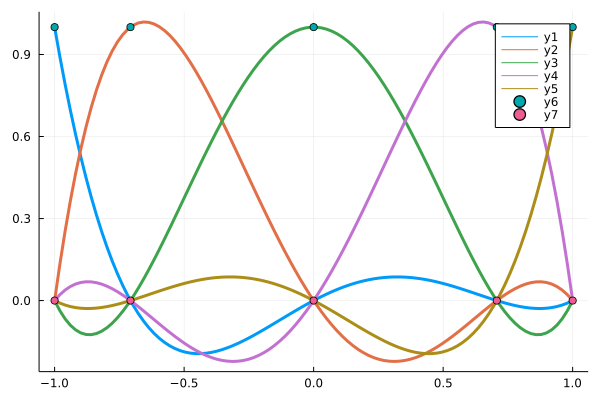

In [2]:
n = 5
x = CosRange(-1, 1, n)
xx = LinRange(-1, 1, 100)
Tx = vander_chebyshev(x)
Txx, dTxx, ddTxx = chebdiff(xx, n)
plot(xx, Txx / Tx)
scatter!(x, [one.(x) zero.(x)])

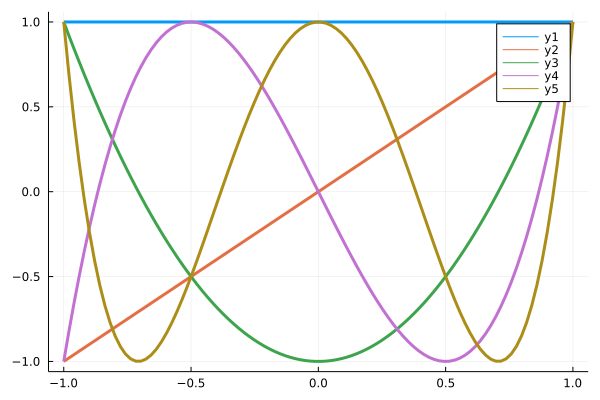

In [3]:
plot(xx, Txx)

# Solving a BVP on Chebyshev nodes

In [4]:
function poisson_cheb(n, rhsfunc, leftbc=(0, zero), rightbc=(0, zero))
    x = CosRange(-1, 1, n)
    T, dT, ddT = chebdiff(x)
    L = -ddT
    rhs = rhsfunc.(x)
    for (index, (deriv, func)) in
            [(1, leftbc), (n, rightbc)]
        L[index,:] = (T, dT)[deriv+1][index,:]
        rhs[index] = func(x[index])
    end
    x, L / T, rhs
end

poisson_cheb (generic function with 3 methods)

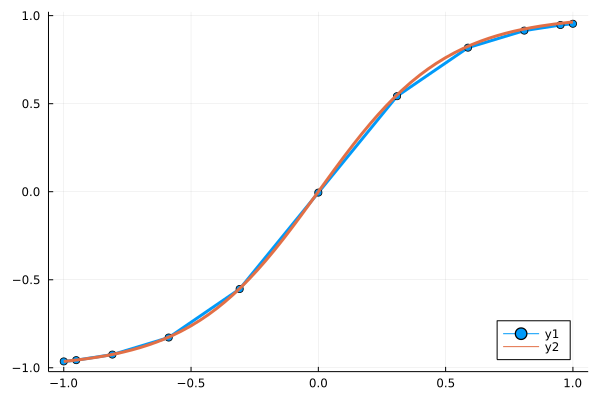

In [5]:
manufactured(x) = tanh(2x)
d_manufactured(x) = 2*cosh(2x)^-2
mdd_manufactured(x) = 8 * tanh(2x) / cosh(2x)^2
x, A, rhs = poisson_cheb(11, mdd_manufactured,
    (0, manufactured), (1, d_manufactured))
plot(x, A \ rhs, marker=:circle)
plot!(manufactured, legend=:bottomright)

# "spectral" (exponential) convergence

In [9]:
function poisson_fd_error(n; spoints=3)
    x = LinRange(-2, 2, n)
    L, rhs = poisson_fd(x, spoints, x -> 2 * tanh(x) / cosh(x)^2,
        left = (0, tanh),
        right = (1, x -> cosh(x)^-2))
    u = L \ rhs
    norm(u - tanh.(x), Inf)
end

poisson_fd_error (generic function with 1 method)

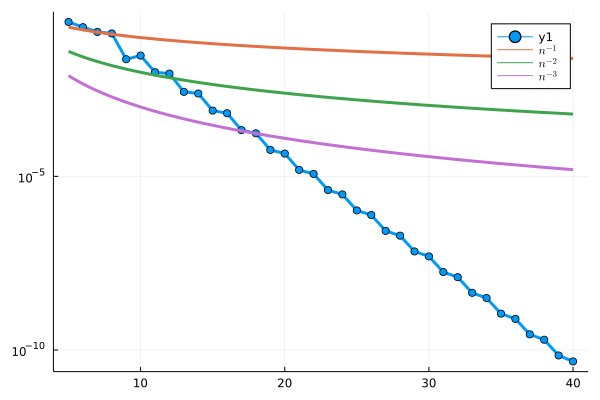

In [10]:
function poisson_error(n)
    x, A, rhs = poisson_cheb(n, mdd_manufactured, (0, manufactured), (1, d_manufactured))
    u = A \ rhs
    norm(u - manufactured.(x), Inf)
end

ns = 5:40
plot(ns, abs.(poisson_error.(ns)), marker=:circle, yscale=:log10)
ps = [1 2 3]
plot!([n -> n^-p for p in ps], label=map(p -> "\$n^{-$p}\$", ps))

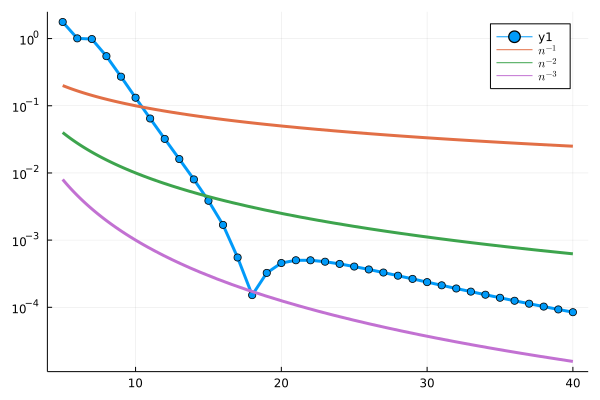

In [11]:
plot(ns, [poisson_fd_error(n, spoints=5) for n in ns], 
    marker=:circle, yscale=:log10)
plot!([n -> n^-p for p in ps], label=map(p -> "\$n^{-$p}\$", ps))

# Variable coefficients

* Heat conduction: steel, brick, wood, foam
* Electrical conductivity: copper, rubber, air
* Elasticity: steel, rubber, concrete, rock
* Linearization of nonlinear materials
  * ketchup, glacier ice, rocks (mantle/lithosphere)

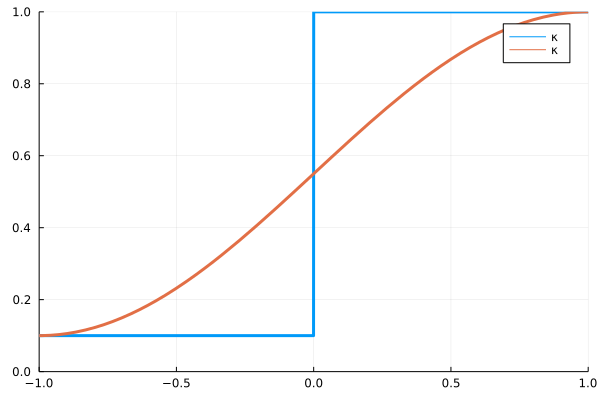

In [14]:
kappa_step(x) = .1 + .9 * (x > 0)
kappa_smooth(x) = .55 + .45 * sin(pi*x/2)
plot([kappa_step, kappa_smooth], xlims=(-1, 1), ylims=(0, 1), label="κ")

\begin{align}
-\big(\kappa(x) u_x\big)_x &= 0 & u(-1) &= 0 & \kappa u_x(1) &= 1
\end{align}

* What physical scenario could this represent?
* Qualitatively, what would a solution look like?

# A naive finite difference solver

| Conservative (divergence) form | Non-divergence form |
| ------------------------------ | ------------------- |
| $-(\kappa u_x)_x = 0$           | $-\kappa u_{xx} - \kappa_x u_x = 0$ |

In [15]:
function poisson_nondivergence(x, spoints, kappa, forcing; leftbc=(0, zero), rightbc=(0, zero))
    n = length(x)
    L = zeros(n, n)
    rhs = forcing.(x)
    kappax = kappa.(x)
    for i in 2:n-1
        jleft = min(max(1, i-spoints÷2), n-spoints+1)
        js = jleft : jleft + spoints - 1
        kappa_x = fdstencil(x[js], x[i], 1) * kappax[js]
        L[i, js] = -fdstencil(x[js], x[i], 2) .* kappax[i] - fdstencil(x[js], x[i], 1) * kappa_x
    end
    L[1,1:spoints] = fdstencil(x[1:spoints], x[1], leftbc[1])
    if leftbc[1] == 1
        L[1, :] *= kappax[1]
    end
    L[n,n-spoints+1:n] = fdstencil(x[n-spoints+1:n], x[n], rightbc[1])
    if rightbc[1] == 1
        L[n, :] *= kappax[n]
    end
    rhs[1] = leftbc[2](x[1])
    rhs[n] = rightbc[2](x[n])
    L, rhs
end

poisson_nondivergence (generic function with 1 method)

# Try it

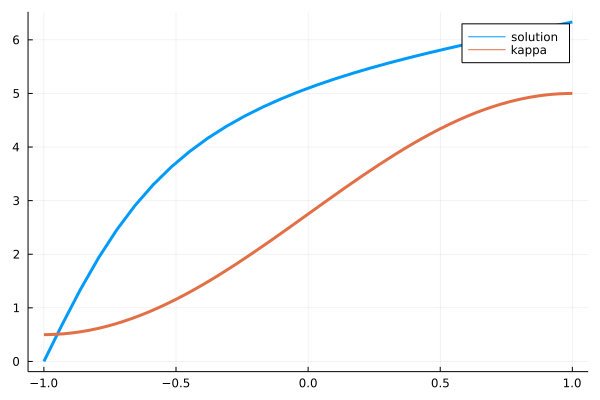

In [17]:
x = LinRange(-1, 1, 30)
L, rhs = poisson_nondivergence(x, 3, kappa_smooth, zero, rightbc=(1, one))
u = L \ rhs
plot(x, u, label="solution")
plot!(x -> 5*kappa_smooth(x), label="kappa")

# Manufactured solutions for variable coefficients

In [27]:
manufactured(x) = tanh(2x)
d_manufactured(x) = 2*cosh(2x)^-2
d_kappa_smooth(x) = .45*pi/2 * cos(pi*x/2)
flux_manufactured_kappa_smooth(x) = kappa_smooth(x) * d_manufactured(x)
function forcing_manufactured_kappa_smooth(x)
    8 * tanh(2x) / cosh(2x)^2 * kappa_smooth(x) -
     d_kappa_smooth(x) * d_manufactured(x)
end
x = LinRange(-1, 1, 20)
L, rhs = poisson_nondivergence(x, 3, kappa_smooth,
    forcing_manufactured_kappa_smooth,
    leftbc=(0, manufactured), rightbc=(1, flux_manufactured_kappa_smooth))
u = L \ rhs;

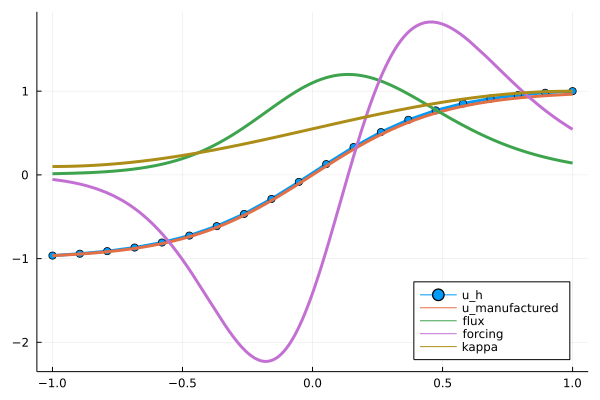

In [26]:
plot(x, u, marker=:circle, legend=:bottomright, label="u_h")
plot!([manufactured flux_manufactured_kappa_smooth forcing_manufactured_kappa_smooth kappa_smooth],
label=["u_manufactured" "flux" "forcing" "kappa"])

# Convergence

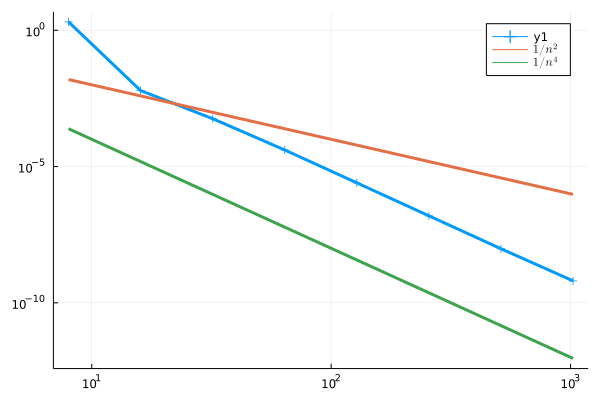

In [28]:
function poisson_error(n, spoints=3)
    x = LinRange(-1, 1, n)
    L, rhs = poisson_nondivergence(x, spoints, kappa_smooth,
        forcing_manufactured_kappa_smooth,
        leftbc=(0, manufactured), rightbc=(1, flux_manufactured_kappa_smooth))
    u = L \ rhs
    norm(u - manufactured.(x), Inf)
end
ns = 2 .^ (3:10)
plot(ns, poisson_error.(ns, 5), marker=:auto, xscale=:log10, yscale=:log10)
plot!([n -> n^-2, n -> n^-4], label=["\$1/n^2\$" "\$1/n^4\$"])

#  ✅ Verified!

# Let's try with the discontinuous coefficients

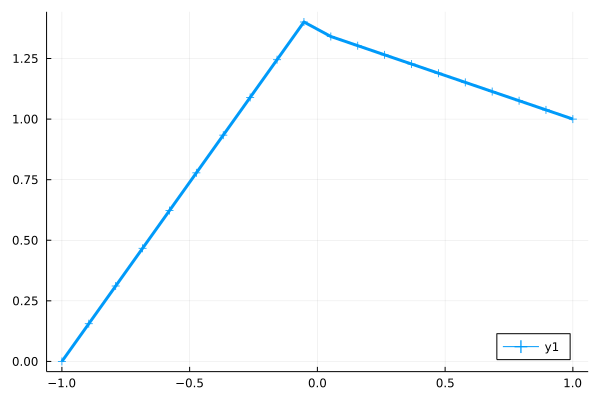

In [29]:
x = LinRange(-1, 1, 20)
L, rhs = poisson_nondivergence(x, 3, kappa_step,
    zero,
    leftbc=(0, zero), rightbc=(0, one))
u = L \ rhs
plot(x, u, marker=:auto, legend=:bottomright)

# Discretizing in conservative form

| Conservative (divergence) form | Non-divergence form |
| ------------------------------ | ------------------- |
| $-(\kappa u_x)_x = 0$           | $-\kappa u_{xx} - \kappa_x u_x = 0$ |

In [30]:
function poisson_conservative(n, kappa, forcing; leftbc=(0, zero), rightbc=(0, zero))
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    L = zeros(n, n)
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    for i in 2:n-1
        flux_L = kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1)
        flux_R = kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1)
        js = i-1:i+1
        weights = -fdstencil(xstag[i-1:i], x[i], 1)
        L[i, i-1:i+1] = weights[1] * [flux_L..., 0] + weights[2] * [0, flux_R...]
    end
    if leftbc[1] == 0
        L[1, 1] = 1
        rhs[1] = leftbc[2](x[1])
        rhs[2:end] -= L[2:end, 1] * rhs[1]
        L[2:end, 1] .= 0
    end
    if rightbc[1] == 0
        L[end,end] = 1
        rhs[end] = rightbc[2](x[end])
        rhs[1:end-1] -= L[1:end-1,end] * rhs[end]
        L[1:end-1,end] .= 0
    end
    x, L, rhs
end

poisson_conservative (generic function with 1 method)

# Compare conservative vs non-divergence forms

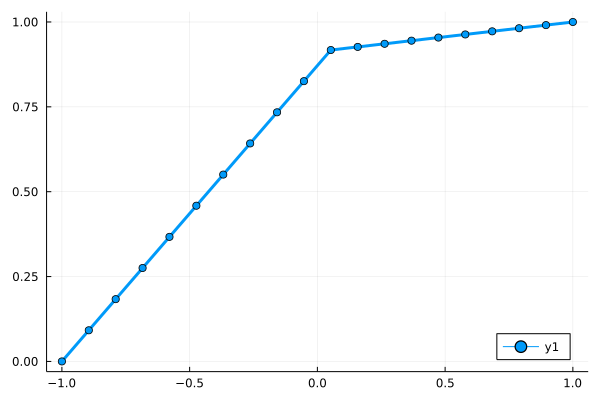

In [36]:
forcing = zero # one
x, L, rhs = poisson_conservative(20, kappa_step,
    forcing, leftbc=(0, zero), rightbc=(0, one))
u = L \ rhs
plot(x, u, marker=:circle, legend=:bottomright)

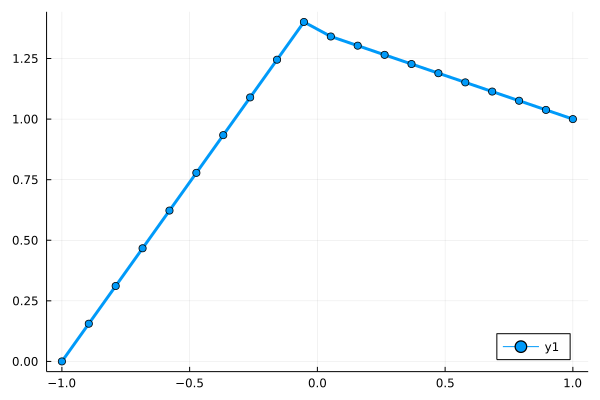

In [38]:
x = LinRange(-1, 1, 20)
L, rhs = poisson_nondivergence(x, 3, kappa_step,
    forcing, leftbc=(0, zero), rightbc=(0, one))
u = L \ rhs
plot(x, u, marker=:circle, legend=:bottomright)

# Continuity of flux

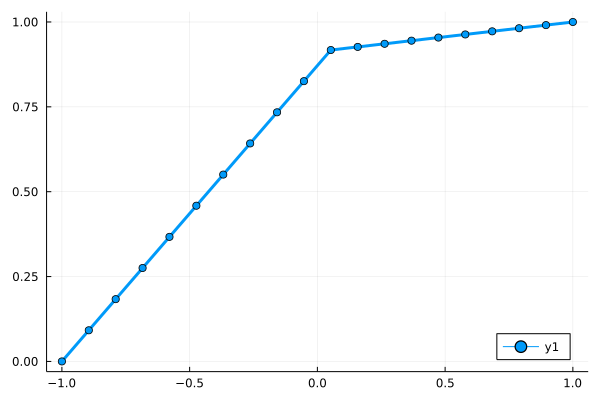

In [40]:
forcing = zero
x, L, rhs = poisson_conservative(20, kappa_step,
    forcing, leftbc=(0, zero), rightbc=(0, one))
u = L \ rhs
plot(x, u, marker=:circle, legend=:bottomright)

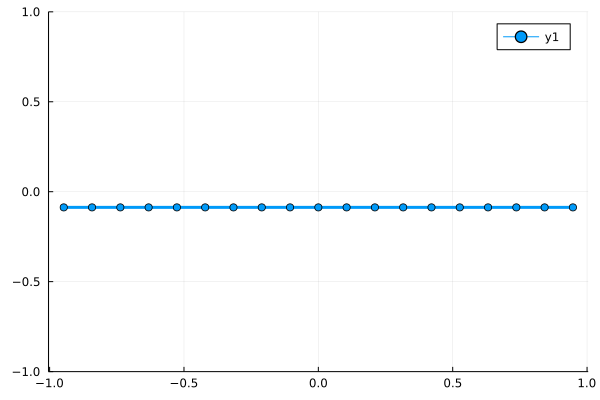

In [41]:
xstag = (x[1:end-1] + x[2:end]) ./ 2
du = (u[1:end-1] - u[2:end]) ./ diff(x)
plot(xstag, [du .* kappa_step.(xstag)], marker=:circle, ylims=[-1, 1])

# Manufactured solutions with discontinuous coefficients

* We need to be able to evaluate derivatives of the flux $-\kappa u_x$.
* A physically-realizable solution would have continuous flux, but we we'd have to be making a physical solution to have that in verification.
* Idea: replace the discontinuous function with a continuous one with a rapid transition.

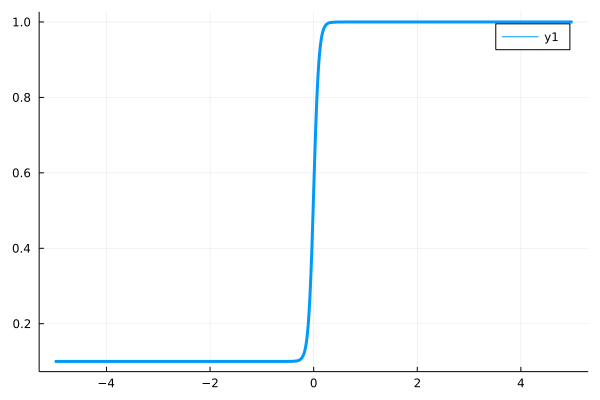

In [42]:
kappa_tanh(x, epsilon=.1) = .55 + .45 * tanh(x / epsilon)
d_kappa_tanh(x, epsilon=.1) = .45/epsilon * cosh(x/epsilon)^-2
plot([kappa_tanh])

# Solving with the smoothed step $\kappa$

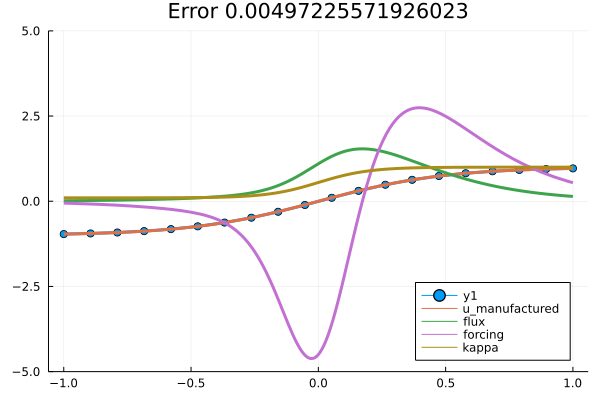

In [58]:
kappa_tanh(x, epsilon=.2) = .55 + .45 * tanh(x / epsilon)
d_kappa_tanh(x, epsilon=.2) = .45/epsilon * cosh(x/epsilon)^-2
flux_manufactured_kappa_tanh(x) = kappa_tanh(x) * d_manufactured(x)
function forcing_manufactured_kappa_tanh(x)
    8 * tanh(2x) / cosh(2x)^2 * kappa_tanh(x) -
    d_kappa_tanh(x) * d_manufactured(x)
end
x, L, rhs = poisson_conservative(20, kappa_tanh,
    forcing_manufactured_kappa_tanh,
    leftbc=(0, manufactured), rightbc=(0, manufactured))
u = L \ rhs
plot(x, u, marker=:circle, legend=:bottomright, title="Error $(norm(u - manufactured.(x), Inf))")
plot!([manufactured flux_manufactured_kappa_tanh forcing_manufactured_kappa_tanh kappa_tanh],
label=["u_manufactured" "flux" "forcing" "kappa"], ylim=(-5, 5))

# Convergence

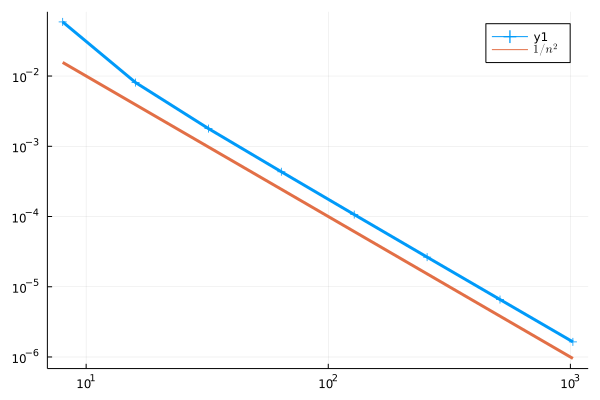

In [59]:
function poisson_error(n, spoints=3)
    x, L, rhs = poisson_conservative(n, kappa_tanh,
        forcing_manufactured_kappa_tanh,
        leftbc=(0, manufactured), rightbc=(0, manufactured))
    u = L \ rhs
    norm(u - manufactured.(x), Inf)
end
ns = 2 .^ (3:10)
plot(ns, poisson_error.(ns, 3), marker=:auto, xscale=:log10, yscale=:log10)
plot!(n -> n^-2, label="\$1/n^2\$")

# Outlook

* Manufactured solutions can be misleading for verification in the presence of rapid coefficient variation.
  * Forcing terms may be poorly resolved on the grid
* Non-conservative methods are scary
  * Can look great during verification on smooth problems, then break catastrophically
* Conservative methods are generally robust, but now we have choices to make
  * What if $\kappa(x)$ is gridded data? How do we evaluate at staggered points?
  * What does this mean for boundary conditions, $\kappa u_x = g$
  * What do staggered points mean on unstructured/adaptive meshes?
  * Which terms should we evaluate where?